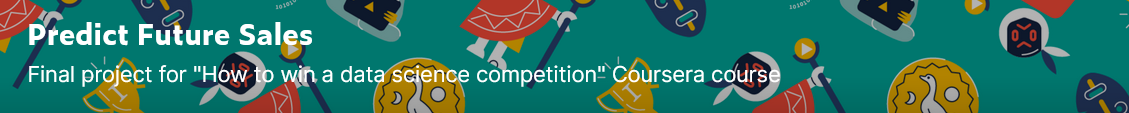

#Outline
1. Load data
2. Data exploration (EDA)
3. Data cleaning and Preprocessing
4. Feature engineering
5. Model fitting

In [23]:
!pip install shap

In [24]:
import os
import numpy as np
import pandas as pd
import itertools
import pickle
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from xgboost import XGBRegressor
from xgboost import plot_importance

import lightgbm as lgb

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/DSAI/hw4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Load data

In [25]:
sales_train = pd.read_csv("./sales_train.csv")
test = pd.read_csv("./test.csv")
item_categories = pd.read_csv("./item_categories.csv")
items = pd.read_csv("./items.csv")
shops = pd.read_csv("./shops.csv")

# 2. EDA

Total Sales of the company

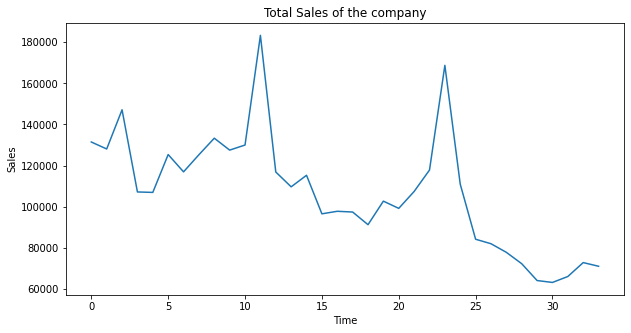

In [26]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum().astype('float')
plt.figure(figsize=(10,5))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

Outliers

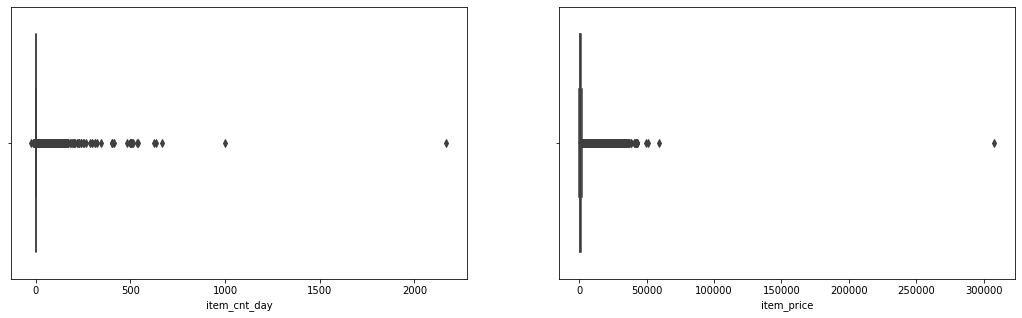

<Figure size 720x288 with 0 Axes>

In [27]:
f, axes = plt.subplots(1, 2, figsize=(18,5))
sns.boxplot(x=sales_train['item_cnt_day'], ax=axes[0])

plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train['item_price'], ax=axes[1])

#3. Data cleaning and Preprocessing

Remove Outliers with price > 100000 and sales > 1000


In [28]:
sales_train = sales_train.drop(sales_train[sales_train['item_price']>100000].index)
sales_train = sales_train.drop(sales_train[sales_train['item_cnt_day']>1000].index)

Replace non-positive price items with the median value 

In [29]:
median = sales_train[(sales_train['shop_id'] == 32) & (sales_train['item_id'] == 2973) & (sales_train['date_block_num'] == 4) & 
                     (sales_train['item_price'] > 0)].item_price.median()
sales_train.loc[sales_train['item_price'] < 0, 'item_price'] = median

Unify duplicated shops

In [30]:
sales_train.loc[sales_train['shop_id'] == 11,'shop_id'] = 10
sales_train.loc[sales_train['shop_id'] == 57,'shop_id'] = 0
sales_train.loc[sales_train['shop_id'] == 58,'shop_id'] = 1
sales_train.loc[sales_train['shop_id'] == 40,'shop_id'] = 39
test.loc[test['shop_id'] == 11,'shop_id'] = 10
test.loc[test['shop_id'] == 57,'shop_id'] = 0
test.loc[test['shop_id'] == 58,'shop_id'] = 1
test.loc[test['shop_id'] == 40,'shop_id'] = 39

Preprocessing

In [31]:
def create_testlike_train(sales_train, test=None):
    matrix = []
    cols = ['date_block_num','shop_id','item_id']
    for i in sales_train.date_block_num.unique():
        x = itertools.product([i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique())
        matrix.append(np.array(list(x)))
    matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

    # Aggregate item_id / shop_id item_cnts at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"))
    matrix = matrix.merge(sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"])

    # Add test data
    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")
        matrix = pd.concat([matrix, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty with 0
    matrix.item_cnt_month = matrix.item_cnt_month.fillna(0)

    # change data type
    matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
    matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
    matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
    matrix['item_id'] = matrix['item_id'].astype(np.int16)
    matrix['item_cnt_month'] = matrix['item_cnt_month'].astype(np.float16)
    
    return matrix
    
matrix = create_testlike_train(sales_train, test)

#3. Feature engineering

Item category features

In [32]:
def add_item_category(matrix, items, item_categories):
    items['item_category_id'] = items['item_category_id'].astype(np.int8)
    matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

    # type_category
    type_category = item_categories["item_category_name"].str.split("-").map(lambda x: x[0])
    item_categories["type_category"] = type_category.str.split("(").map(lambda x: x[0])
    item_categories["type_code"] = item_categories["type_category"].factorize()[0].astype(np.int8)
    matrix = matrix.merge(item_categories[['item_category_id', "type_code"]], on='item_category_id', how='left')

    # subtype_category
    item_categories['split'] = item_categories['item_category_name'].str.split('-')
    item_categories['subtype_category'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()) # if subtype is nan then type
    item_categories["subtype_code"] = item_categories["subtype_category"].factorize()[0].astype(np.int8)
    matrix = matrix.merge(item_categories[['item_category_id', "subtype_code"]], on='item_category_id', how='left')

    return matrix
  
matrix = add_item_category(matrix, items, item_categories)

shop

In [33]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0].astype(np.int8)
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)

sales

In [34]:
def add_sale_feature(matrix):
    first_item_block = matrix.groupby(['item_id'])['date_block_num'].min().reset_index()
    first_item_block['item_first_interaction'] = 1

    first_shop_item_buy_block = matrix[matrix['item_cnt_month'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
    first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

    matrix = pd.merge(matrix, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
    matrix = pd.merge(matrix, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

    matrix['first_date_block_num'].fillna(100, inplace=True)
    matrix['shop_item_sold_before'] = (matrix['first_date_block_num'] < matrix['date_block_num']).astype('int8')
    matrix.drop(['first_date_block_num'], axis=1, inplace=True)

    matrix['item_first_interaction'].fillna(0, inplace=True)
    matrix['shop_item_sold_before'].fillna(0, inplace=True)
    matrix['item_first_interaction'] = matrix['item_first_interaction'].astype('int8')  
    matrix['shop_item_sold_before'] = matrix['shop_item_sold_before'].astype('int8') 

    return matrix

matrix = add_sale_feature(matrix)

lag

In [35]:
def add_lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
        
    return df

In [36]:
#Add sales lags for last 3 months
matrix = add_lag_feature(matrix, [1, 2, 3], 'item_cnt_month')

In [37]:
#Add avg shop/item price lags

def add_price_feature(matrix):
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    group = sales_train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
    matrix = pd.merge(matrix, group, on=index_cols, how='left')
    matrix['avg_shop_price'] = (matrix['avg_shop_price'].fillna(0).astype(np.float16))

    index_cols = ['item_id', 'date_block_num']
    group = sales_train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")
    matrix = pd.merge(matrix, group, on=index_cols, how='left')
    matrix['avg_item_price'] = (matrix['avg_item_price'].fillna(0).astype(np.float16))

    matrix['item_shop_price_avg'] = (matrix['avg_shop_price'] - matrix['avg_item_price']) / matrix['avg_item_price']
    matrix['item_shop_price_avg'].fillna(0, inplace=True)

    matrix = add_lag_feature(matrix, [1], 'item_shop_price_avg')
    matrix.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)

    return matrix

matrix = add_price_feature(matrix)

encoding

In [38]:
def add_encoding_feature(matrix):
    #Add target encoding for items
    item_id_target_mean = matrix.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
    matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','item_id'], how='left')
    matrix['item_target_enc'] = (matrix['item_target_enc'].fillna(0).astype(np.float16))
    matrix = add_lag_feature(matrix, [1], 'item_target_enc')
    matrix.drop(['item_target_enc'], axis=1, inplace=True)

    #Add target encoding for item/city
    item_id_target_mean = matrix.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
        "item_cnt_month": "item_loc_target_enc"}, errors="raise")
    matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')
    matrix['item_loc_target_enc'] = (matrix['item_loc_target_enc'].fillna(0).astype(np.float16))
    matrix = add_lag_feature(matrix, [1], 'item_loc_target_enc')
    matrix.drop(['item_loc_target_enc'], axis=1, inplace=True)

    #For new items add avg category sales
    item_id_target_mean = matrix[matrix['item_first_interaction'] == 1].groupby(['date_block_num','type_code'])['item_cnt_month'].mean().reset_index().rename(columns={
        "item_cnt_month": "new_item_cat_avg"}, errors="raise")
    matrix = pd.merge(matrix, item_id_target_mean, on=['date_block_num','type_code'], how='left')
    matrix['new_item_cat_avg'] = (matrix['new_item_cat_avg'].fillna(0).astype(np.float16))
    matrix = add_lag_feature(matrix, [1], 'new_item_cat_avg')
    matrix.drop(['new_item_cat_avg'], axis=1, inplace=True)

    return matrix

matrix = add_encoding_feature(matrix)

In [39]:
def add_lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

matrix = add_lag_feature_adv(matrix, [1], 'item_cnt_month')

Remove last 3 months data

In [40]:
matrix.fillna(0, inplace=True)
matrix = matrix[(matrix['date_block_num'] > 2)]
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,type_code,subtype_code,city_code,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_target_enc_lag_1,item_loc_target_enc_lag_1,new_item_cat_avg_lag_1,item_cnt_month_lag_1_adv
1122795,3,25,8092,3.0,40,10,22,14,0,1,1.0,0.0,4.0,0.019669,0.586914,0.666504,0.705566,7.0
1122796,3,25,7850,3.0,30,8,15,14,0,1,5.0,1.0,6.0,0.014656,1.869141,2.916016,6.648438,0.0
1122797,3,25,8051,3.0,66,13,47,14,0,0,0.0,0.0,0.0,-1.000000,0.043488,0.000000,0.122742,0.0
1122798,3,25,8088,1.0,55,12,36,14,0,1,1.0,1.0,0.0,0.000000,0.130493,0.166626,0.185913,0.0
1122799,3,25,8089,1.0,55,12,36,14,0,1,0.0,1.0,0.0,-1.000000,0.478271,0.666504,0.185913,2.0


Draw correlation matrix

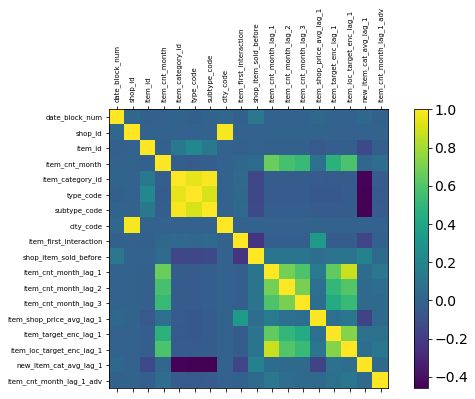

In [41]:
matrix.drop(['ID'], axis=1, inplace=True, errors='ignore')

cor_matrix = matrix[matrix['date_block_num']<34]
f = plt.figure(figsize=(9, 5))
plt.matshow(cor_matrix.corr(), fignum=f.number)
plt.xticks(range(cor_matrix.shape[1]),cor_matrix.columns, fontsize=7, rotation=90)
plt.yticks(range(cor_matrix.shape[1]), cor_matrix.columns, fontsize=7)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Save dataset

In [42]:
matrix.to_pickle('dataset.pkl')

#5. Model fitting

load dataset

In [43]:
matrix = pd.read_pickle('df_8.pkl')
matrix.info()
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del matrix

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9933482 entries, 1122795 to 11056276
Data columns (total 18 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   date_block_num             int8   
 1   shop_id                    int8   
 2   item_id                    int16  
 3   item_cnt_month             float16
 4   item_category_id           int8   
 5   type_code                  int8   
 6   subtype_code               int8   
 7   city_code                  int8   
 8   item_first_interaction     int8   
 9   shop_item_sold_before      int8   
 10  item_cnt_month_lag_1       float16
 11  item_cnt_month_lag_2       float16
 12  item_cnt_month_lag_3       float16
 13  item_shop_price_avg_lag_1  float16
 14  item_target_enc_lag_1      float16
 15  item_loc_target_enc_lag_1  float16
 16  new_item_cat_avg_lag_1     float16
 17  item_cnt_month_lag_1_adv   float16
dtypes: float16(9), int16(1), int8(8)
memory usage: 341.0 MB


train

In [44]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [  
                        'subtype_code',
                        'type_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'subtype_code', 'type_code']
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 3.46563	valid_1's rmse: 2.66598
[10]	training's rmse: 3.42095	valid_1's rmse: 2.63696
[15]	training's rmse: 3.37795	valid_1's rmse: 2.6077
[20]	training's rmse: 3.33633	valid_1's rmse: 2.58002
[25]	training's rmse: 3.29685	valid_1's rmse: 2.55515
[30]	training's rmse: 3.2567	valid_1's rmse: 2.53164
[35]	training's rmse: 3.21698	valid_1's rmse: 2.50937
[40]	training's rmse: 3.17842	valid_1's rmse: 2.48768
[45]	training's rmse: 3.14201	valid_1's rmse: 2.46826
[50]	training's rmse: 3.10598	valid_1's rmse: 2.4479
[55]	training's rmse: 3.07158	valid_1's rmse: 2.43118
[60]	training's rmse: 3.03871	valid_1's rmse: 2.41436
[65]	training's rmse: 3.00675	valid_1's rmse: 2.39646
[70]	training's rmse: 2.97507	valid_1's rmse: 2.37984
[75]	training's rmse: 2.94509	valid_1's rmse: 2.3597
[80]	training's rmse: 2.91736	valid_1's rmse: 2.34548
[85]	training's rmse: 2.88976	valid_1's rmse: 2.33399
[90]	training's rmse: 2.

predict

In [45]:
test = pd.read_csv('./test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

# save submission
submission.to_csv('submission.csv', index=False)

Draw feature importance

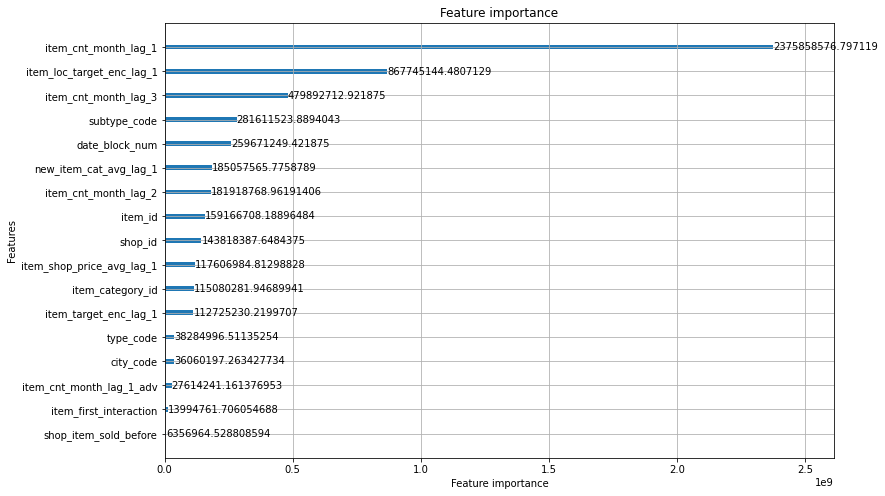

In [46]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

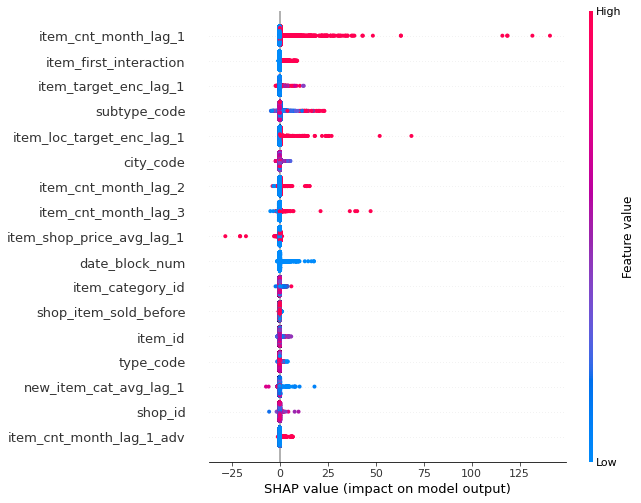

In [47]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)